In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf
tf.config.optimizer.set_experimental_options({"layout_optimizer": False, "shape_optimizer": False, "remapping": False, "constant_folding": False, "arithmetic_optimization": False, "dependency_optimization": False, "loop_optimization": False, "layout_optimizer": False, "memory_optimization": False})
import warnings
warnings.filterwarnings("ignore")


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
import os
base_dir = '/content/drive/MyDrive/Dataset'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

In [6]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [7]:
class_names = ['glioma','meningioma','notumor','pituitary']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (100, 100)
print(nb_classes)
class_names_label

4


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [8]:
def load_data(base_dir):
    datasets = [os.path.join(base_dir, 'Train'), os.path.join(base_dir, 'Test')]
    output = []

    for dataset in datasets:
        images = []
        labels = []

        print("Loading {}".format(dataset))

        for class_folder, label in class_names_label.items():
            folder_path = os.path.join(dataset, class_folder)

            if os.path.exists(folder_path):
                for file in tqdm(os.listdir(folder_path)):
                    img_path = os.path.join(folder_path, file)

                    image = cv2.imread(img_path)
                    image = cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

                    images.append(image)
                    labels.append(label)
            else:
                print(f"Folder {class_folder} not found in {dataset}. Skipping...")

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        output.append((images, labels))

    return output


base_dir = '/content/drive/MyDrive/Dataset'
(x_train, y_train), (x_test, y_test) = load_data(base_dir)


Loading /content/drive/MyDrive/Dataset/Train


100%|██████████| 1458/1458 [00:34<00:00, 42.80it/s] 


Loading /content/drive/MyDrive/Dataset/Test


100%|██████████| 300/300 [00:23<00:00, 12.72it/s] 


In [9]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (5715, 100, 100, 3)
y_train shape: (5715,)
X_test shape: (1311, 100, 100, 3)
y_test shape: (1311,)


In [10]:
n_train = y_train.shape[0]
n_test = y_test.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 5715
Number of testing examples: 1311
Each image is of size: (100, 100)


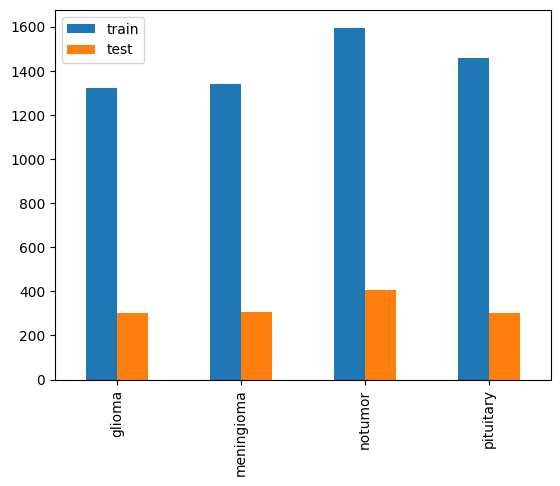

In [11]:
import pandas as pd
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_names
            ).plot.bar()
plt.show()

In [12]:
x_train=x_train/255.0
x_test=x_test/255.0

In [13]:
from tensorflow.keras.utils import to_categorical
y1_train = to_categorical(y_train, 4)
y1_test = to_categorical(y_test,4)

In [14]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

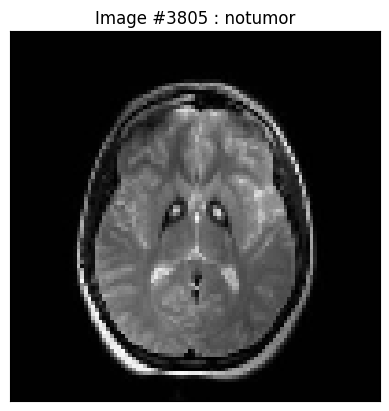

In [15]:
display_random_image(class_names, x_train, y_train)

In [16]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

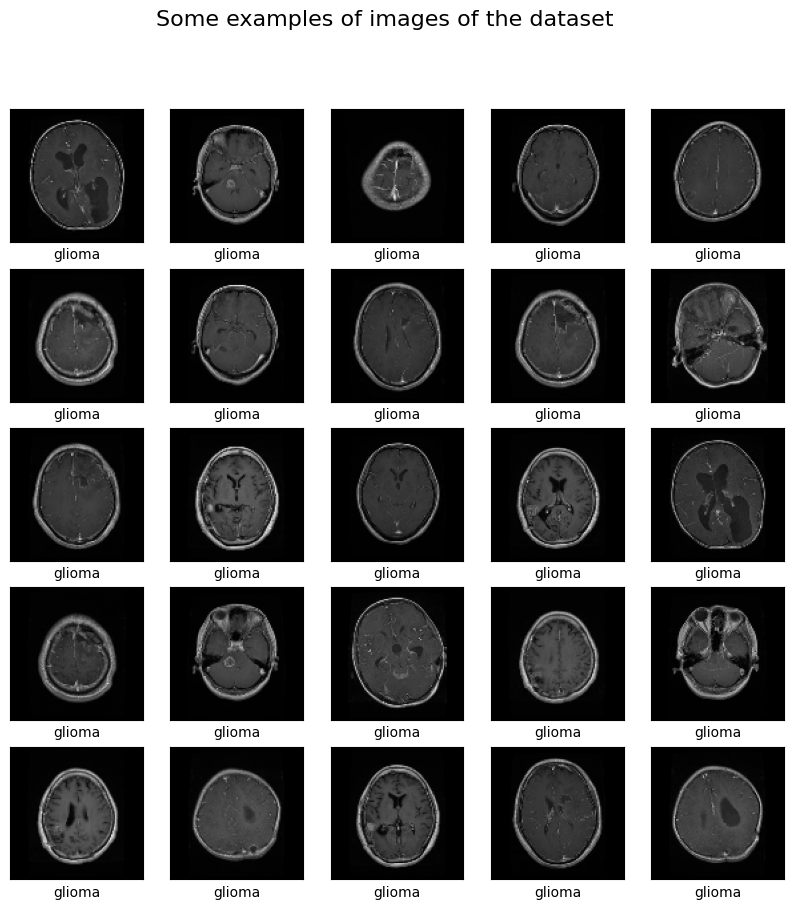

In [17]:
display_examples(class_names, x_train, y_train)

In [18]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout
import tensorflow as tf
#from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [19]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, layers
# from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [20]:
# Define the CNN model creation function
def create_cnn_model(filters1,filters2,filters3, kernel_size1,kernel_size2,kernel_size3, pool_size1,pool_size2,pool_size3, dense_units1,dense_units2,dense_units3,input_shape):
    model1 = models.Sequential()
    #model.add(layers.Input(shape=input_shape))
    model1.add(layers.Conv2D(filters1, kernel_size1, activation='relu',input_shape=input_shape)),
    model1.add(layers.MaxPooling2D(pool_size1)),
    model1.add(layers.Dropout(0.2))

    model1.add(layers.Conv2D(filters2, kernel_size2, activation='relu')),
    model1.add(layers.MaxPooling2D(pool_size2)),
    model1.add(layers.Dropout(0.2))

    model1.add(layers.Conv2D(filters3, kernel_size3, activation='relu')),
    model1.add(layers.MaxPooling2D(pool_size3)),
    model1.add(layers.Dropout(0.2))

    # Flatten the output for the fully connected layers
    model1.add(layers.Flatten())

    # Fully connected layers
    model1.add(layers.Dense(dense_units1, activation='relu'))
    model1.add(layers.Dense(dense_units2, activation='relu'))
    model1.add(layers.Dense(dense_units3, activation='relu'))
    model1.add(layers.Dropout(0.2))

    # Output layer
    model1.add(layers.Dense(4, activation='softmax'))


    model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model1


In [21]:


    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(50, (3, 3), activation='relu', input_shape=(100,100,3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(70, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(100, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Flatten the output for the fully connected layers
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.2))

    # Output layer
    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    #model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
    #y_pred = model.predict(x_test)
    #y_pred = np.argmax(y_pred, axis=1)
    #accuracy = accuracy_score(y_test, y_pred)
    #print(accuracy)



# Assuming input shape is (224, 224, 1) for grayscale images and 8 output classes
#model = create_custom_cnn(input_shape=(100, 100, 1), num_classes=9)

# Display the model summary
#model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 50)          │           1,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 49, 49, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 70)          │          31,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 70)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 23, 23, 70)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 100)         │          63,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │       5,000,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,098,574 (19.45 MB)

 Trainable params: 5,098,574 (19.45 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [23]:
batch_size = 8
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y1_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

In [24]:
import time
from sklearn.linear_model import LinearRegression
import math
start_time = time.time()

history = model.fit(train_generator,
              epochs=1,
              steps_per_epoch=steps_per_epoch,
              validation_data=(x_test, y1_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )
elapsed_time = time.time() - start_time
print(elapsed_time)

714/714 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.5366 - loss: 1.0549 - val_accuracy: 0.5866 - val_loss: 1.1857
37.53276467323303


In [25]:
evaluation = model.evaluate(x_train, y1_train)
print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6554 - loss: 0.9088
Train Accuracy : 58.83%


In [26]:
evaluation = model.evaluate(x_test, y1_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5902 - loss: 1.2067
Test Accuracy : 58.66%


In [27]:

# Define the fitness function for GWO
#from keras.callbacks import EarlyStopping  # Add this import
def fitness_function(solution):

    # Evaluate the model
    y_pred = model.predict(x_train)
    y_pred = np.argmax(y_pred, axis=1)
    #accuracy = accuracy_score(y_test, y_pred)
    y1_train_int = np.argmax(y1_train, axis=1) if len(y1_train.shape) > 1 else y1_train

    accuracy = accuracy_score(y1_train_int, y_pred)
    #accuracy = model.evaluate(x_train, y1_train)
    #print(f'Train Accuracy : {evaluation[1] * 100:.2f}%')

    # Minimize the negative accuracy
    return -accuracy


In [28]:

# Define the update_position function
def update_position(alpha, beta, delta, current_position, a, A, C):
    D_alpha = np.abs(C * alpha - current_position)
    D_beta = np.abs(C * beta - current_position)
    D_delta = np.abs(C * delta - current_position)

    #new_position = (alpha - a * D_alpha + A * D_beta) / 2
    new_position = (D_alpha + D_beta + D_delta) / 3


    # Ensure the new position is within the specified bounds
    new_position = np.clip(new_position, lb, ub)

    return new_position


In [29]:

# Define GWO algorithm
def gray_wolf_optimization(num_wolves, num_iterations, num_variables, lb, ub):
    wolves_position = np.random.uniform(low=lb, high=ub, size=(num_wolves, num_variables))
    alpha, beta, delta = wolves_position[:3]
    count=0
    for iteration in range(num_iterations):
        a = 2 - iteration * (2 / num_iterations)  # linearly decreasing value of a

        for i in range(num_wolves):
            fitness = fitness_function(wolves_position[i])
            if fitness < fitness_function(alpha):
                alpha = wolves_position[i].copy()
            elif fitness < fitness_function(beta):
                beta = wolves_position[i].copy()
            elif fitness < fitness_function(delta):
                delta = wolves_position[i].copy()

        for i in range(num_wolves):
            A = 2 * a * np.random.random() - a
            C = 2 * np.random.random()
            wolves_position[i] = update_position(alpha, beta, delta, wolves_position[i], a, A, C)
        count += 1
        print(count)

    return alpha, fitness_function(alpha)
# Main code for CNN hyperparameter optimization using GWO
num_wolves = 3
num_iterations = 2
num_variables = 12  # filters1,filter2,filter3, kernel_size1,kernel_size2,kernel_size3, pool_size1,pool_size2,pool_size3, dense_units1,dense_unit2,dense_unit3
lb = [50,100,150,3,3,3,2,2,2,32,128,256]  # lower bounds
ub = [100,150,200,5,5,5,4,4,4,500,500,500]  # upper bounds
best_solution, best_fitness = gray_wolf_optimization(num_wolves, num_iterations, num_variables, lb, ub)

print("Best Solution:", best_solution)
print("Best Fitness:", -best_fitness)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
2
179/179 ━━━━

In [30]:

# Create the final model using the best solution
best_filters1, best_filters2, best_filters3, best_kernel_size1, best_kernel_size2, best_kernel_size3, best_pool_size1, best_pool_size2, best_pool_size3, best_dense_units1, best_dense_units2, best_dense_units3 = best_solution
optimized_model = create_cnn_model(int(best_filters1),int(best_filters2),int(best_filters3), int(best_kernel_size1),int(best_kernel_size2),int(best_kernel_size3), int(best_pool_size1),int(best_pool_size2),int(best_pool_size3), int(best_dense_units1),int(best_dense_units2),int(best_dense_units3), input_shape=(100, 100, 3))
optimized_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 98, 98, 51)          │           1,428 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 51)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 49, 49, 51)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 100)         │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 23, 23, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 150)         │         135,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 10, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 205)                 │       3,075,205 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 229)                 │          47,174 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 261)                 │          60,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 261)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           1,048 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,366,035 (12.84 MB)

 Trainable params: 3,366,035 (12.84 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# Train the final model on the entire dataset
import time
from sklearn.linear_model import LinearRegression
import math
start_time = time.time()

history_opti = optimized_model.fit(train_generator,
              epochs=38,
              steps_per_epoch=steps_per_epoch,
              validation_data=(x_test, y1_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )
elapsed_time = time.time() - start_time
print(elapsed_time)
#History_opti = optimized_model.fit(x_train, y1_train, epochs=100, batch_size=32)

Epoch 1/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9688 - loss: 0.1035 - val_accuracy: 0.9504 - val_loss: 0.1388
Epoch 2/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 1.0000 - loss: 0.0500 - val_accuracy: 0.9512 - val_loss: 0.1417
Epoch 3/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9535 - loss: 0.1407 - val_accuracy: 0.9710 - val_loss: 0.1021
Epoch 4/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - accuracy: 0.8750 - loss: 0.6637 - val_accuracy: 0.9725 - val_loss: 0.1055
Epoch 5/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9771 - loss: 0.0813 - val_accuracy: 0.9550 - val_loss: 0.1670
Epoch 6/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9535 - val_loss: 0.1680
Epoch 7/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9626 - loss: 0.1103 - val_accuracy: 0.9634 - val_loss: 0.1051
Epoch 8/38
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 1.0000 - loss: 9.6389e-0

In [93]:
# Test the final model on the entire dataset
#optimized_model.fit(x_test, y1_test, epochs=100, batch_size=32)

In [94]:
evaluation = optimized_model.evaluate(x_test, y1_test)
print(f'Test Accuracy after GWO optimizationn: {evaluation[1] * 100:.2f}%')

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9539 - loss: 0.1819
Test Accuracy after GWO optimizationn: 96.95%


In [95]:
evaluation = optimized_model.evaluate(x_train, y1_train)
print(f'Train Accuracy after GWO optimizationn: {evaluation[1] * 100:.2f}%')

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9809 - loss: 0.0553
Train Accuracy after GWO optimizationn: 98.53%


In [96]:

model_save_path = 'best_model.h5'
optimized_model.save(model_save_path)
print(f"Trained model saved to {model_save_path}")

Trained model saved to best_model.h5


In [97]:
y_pred = optimized_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(threshold=np.inf)
print(cm)
type(cm)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[283  16   1   0]
 [  4 284  12   6]
 [  0   0 405   0]
 [  0   1   0 299]]


numpy.ndarray

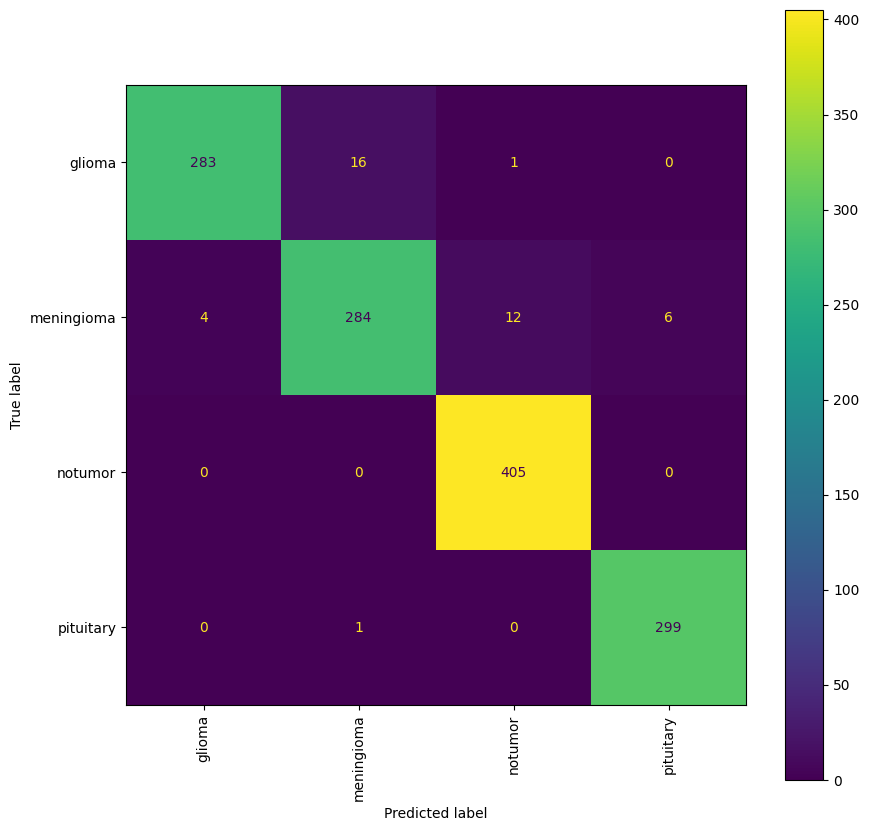

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax)

plt.show()

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       300
           1       0.94      0.93      0.94       306
           2       0.97      1.00      0.98       405
           3       0.98      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



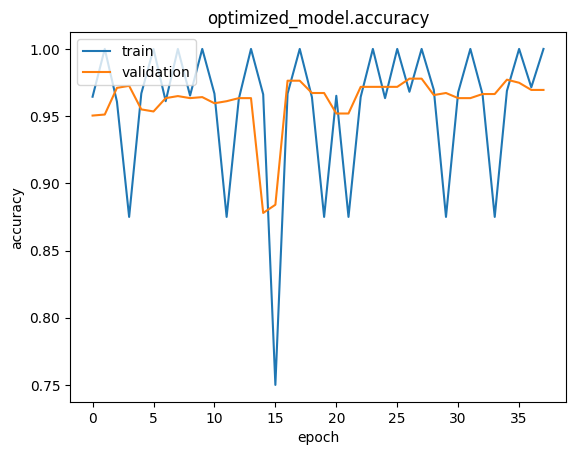

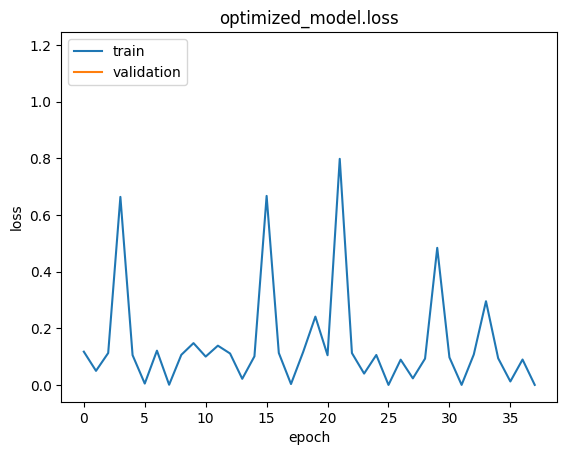

In [100]:
import matplotlib.pyplot as plt
plt.plot(history_opti.history['accuracy'])
plt.plot(history_opti.history['val_accuracy'])
plt.title('optimized_model.accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history_opti.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('optimized_model.loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'], loc='upper left')
plt.show()

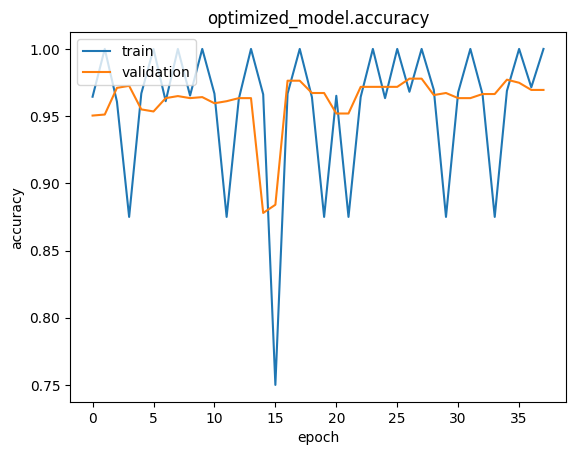

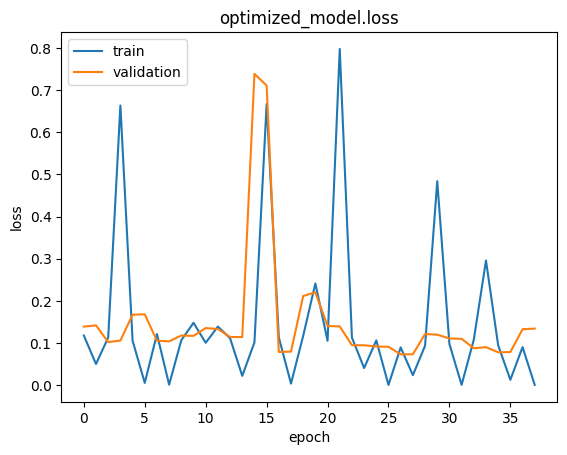

In [101]:
import matplotlib.pyplot as plt
plt.plot(history_opti.history['accuracy'])
plt.plot(history_opti.history['val_accuracy'])
plt.title('optimized_model.accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history_opti.history['loss'])
plt.plot(history_opti.history['val_loss'])
plt.title('optimized_model.loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'], loc='upper left')
plt.show()